# Analyzing,Cleaning,Scaling the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy, math

%matplotlib inline

In [2]:
df = pd.read_csv('emlak_fiyat_boyut_metro.csv')

df

,fiyat,boyut,metro_yakinlik
0,234314.144,98,15
1,228581.528,100,16
2,281626.336,74,13
3,401255.608,229,5
4,458674.256,194,4
...,...,...,...
95,252460.400,84,14
96,310522.592,158,11
97,383635.568,229,12
98,225145.248,99,25


In [3]:
#seems there is not any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fiyat           100 non-null    float64
 1   boyut           100 non-null    int64  
 2   metro_yakinlik  100 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 2.5 KB


In [4]:
#cleaning duplicate values
df.drop_duplicates(inplace=True)
df.shape

(100, 3)

In [5]:
df.describe()

,fiyat,boyut,metro_yakinlik
count,100.000000,100.000000,100.000000
mean,292289.470160,129.960000,12.980000
std,77051.727525,45.389876,6.485384
min,154282.128000,73.000000,1.000000
25%,234280.148000,98.000000,8.000000
50%,280590.716000,106.000000,12.500000
75%,335723.696000,157.000000,17.000000
max,500681.128000,281.000000,30.000000


Text(0, 0.5, 'Price')

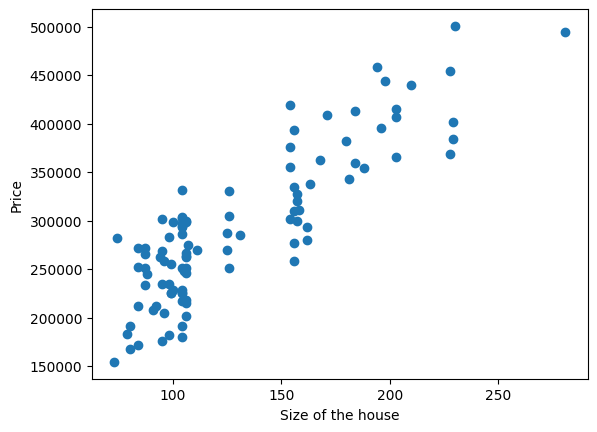

In [6]:
plt.scatter(df['boyut'], df['fiyat'])
plt.xlabel('Size of the house')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

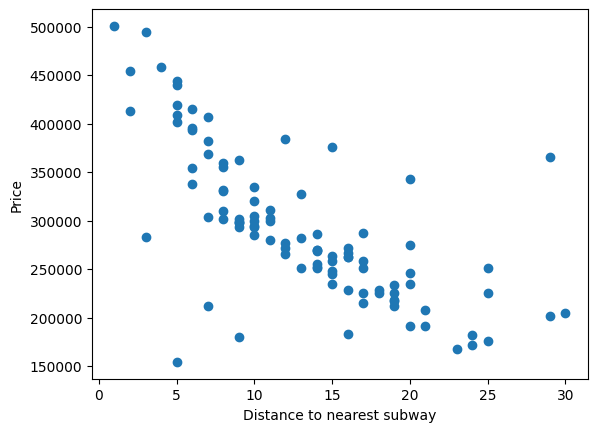

In [7]:
plt.scatter(df['metro_yakinlik'], df['fiyat'])
plt.xlabel('Distance to nearest subway')
plt.ylabel('Price')

    Data is fit for linear regression. For both features, feature - target relationship has linear increase and decrease.

In [8]:
print(df['metro_yakinlik'].max(),df['metro_yakinlik'].min())

30 1


In [9]:
print(df['boyut'].max(),df['boyut'].min())

281 73


    There is too much difference between feature values, to max-min scale makes sense.

In [10]:
def max_min_scaler(X):
    
    X_new = (X - X.min()) / (X.max() - X.min())
    
    return X_new

In [11]:
df_temp = df.drop('fiyat',axis = 1)

columns = list(df_temp)

columns

['boyut', 'metro_yakinlik']

In [12]:
for i in columns:
    df_temp[i] = max_min_scaler(df_temp[i]) 
    
df_temp

,boyut,metro_yakinlik
0,0.120192,0.482759
1,0.129808,0.517241
2,0.004808,0.413793
3,0.750000,0.137931
4,0.581731,0.103448
...,...,...
95,0.052885,0.448276
96,0.408654,0.344828
97,0.750000,0.379310
98,0.125000,0.827586


In [13]:
df['boyut'] = df_temp['boyut']
df['metro_yakinlik'] = df_temp['metro_yakinlik']

df

,fiyat,boyut,metro_yakinlik
0,234314.144,0.120192,0.482759
1,228581.528,0.129808,0.517241
2,281626.336,0.004808,0.413793
3,401255.608,0.750000,0.137931
4,458674.256,0.581731,0.103448
...,...,...,...
95,252460.400,0.052885,0.448276
96,310522.592,0.408654,0.344828
97,383635.568,0.750000,0.379310
98,225145.248,0.125000,0.827586


In [14]:
print(df['metro_yakinlik'].max(),df['metro_yakinlik'].min())

1.0 0.0


In [15]:
print(df['boyut'].max(),df['boyut'].min())

1.0 0.0


# Linear Regression

# 1) Gradient Descent algorithm

In [16]:
y_train = df['fiyat'].to_numpy()

y_train.shape

(100,)

In [17]:
df_X = df.drop('fiyat',axis = 1)

X_train = df_X.to_numpy()

X_train.shape

(100, 2)

# 1a) Cost Function:
     
         J(w,b) = 1/2m( f_wb(x ^ i) - y ^ i) ^ 2  ;  i = 0..m - 1

         ve f_wb(x) = w * x[i] + b 

In [18]:
def compute_cost(X,y,w,b):
    
    m = X.shape[0] 
    
    total_cost = 0
    
    cost_sum = 0
    
    for i in range(m):
        
        f_wb_i = np.dot(X[i], w) + b
        
        cost = (f_wb_i - y[i])**2
        
        cost_sum = cost_sum + cost
        
    total_cost = (1 / (2 * m)) * cost_sum    
    
    return total_cost

In [19]:
b_test = 0.03
w_test = np.array([0.2 ,0.12])
compute_cost(X_train,y_train,w_test,b_test)

45655325999.155365

# 1b) Gradient Descent derivative terms:

       Gradient Descent :
   
           Repeat until convergence: {

    w_j = w_j - a * (dJ(w,b) / dw_j)  ; j = 0..n - 1 (n = numbers of feature , a = learning rate alpha)

    b = b - a * (dJ(w,b) / db)                     (w_j and b updated simultaneously)

    }

    

    (dJ(w,b) / dw_j) = 1/m( f_wb(x ^ i) - y ^ i)x_j ^ i  ; i = 0..m - 1

    (dJ(w,b) / db) =  1/m( f_wb(x ^ i) - y ^ i)

In [20]:
def compute_gradient_derivatives(X,y,w,b):
    
    m,n = X.shape
    dj_dw = np.zeros((n,)) 
    dj_db = 0               
    
    for i in range(m):
        
        error = (np.dot(X[i],w) + b ) - y[i]
        
        for j in range(n):
            
            dj_dw[j] = dj_dw[j] + error*X[i,j] 
            
        dj_db = dj_db + error 
        
    dj_dw = dj_dw / m
    dj_db = dj_db /m
    
    return dj_db , dj_dw

In [21]:
compute_gradient_derivatives(X_train,y_train,w_test,b_test)

(-292289.33581835544, array([ -94399.49695097, -108743.02099216]))

# 1c) Gradient Descent algorithm:

In [22]:
def gradient_descent(X, y, w_in, b_in, compute_cost, compute_gradient_derivatives, alpha, num_iters): 
    
    J_history = []
    w = copy.deepcopy(w_in)  #to keep global w variable
    b = b_in
    
    for i in range(num_iters):

        dj_db,dj_dw = compute_gradient_derivatives(X, y, w, b)

        # Gradient Descent Algorithm , simultaneously updated
        w = w - alpha * dj_dw             
        b = b - alpha * dj_db
      
        # Save cost after every iteration
        if i<100001:      # prevent resource exhaustion 
            J_history.append(compute_cost(X, y, w, b))

        # print the last element of J_history when iteration count reaches %10 of the total iterations
        if i% math.ceil(num_iters / 10) == 0:  
            print(f"Iteration {i}: Cost {J_history[-1]}")
        elif num_iters == len(J_history):
            print(f"Iteration {num_iters}: Cost {J_history[-1]}")
        
    return w, b, J_history

In [23]:
w_init = np.zeros(2)
b_init = 0
iterations = 1000
alpha = 0.1

w_final , b_final , J_hist = gradient_descent(
                X_train, y_train, w_init, b_init , compute_cost, compute_gradient_derivatives, alpha, iterations)

print(f"b,w found by gradient descent: {b_final},{w_final} ")

for i in range(10):
    print(f"prediction: {np.dot(X_train[i], w_final) + b_final}, target value: {y_train[i]}")

Iteration 0: Cost 35699863989.967735
Iteration 100: Cost 1164886118.4049125
Iteration 200: Cost 666398625.9043598
Iteration 300: Cost 550904652.3852284
Iteration 400: Cost 523414153.69281405
Iteration 500: Cost 516368268.184697
Iteration 600: Cost 514226612.9195824
Iteration 700: Cost 513367247.7055878
Iteration 800: Cost 512913361.3991495
Iteration 900: Cost 512630403.06416947
Iteration 1000: Cost 512442543.408926
b,w found by gradient descent: 271611.99932799017,[ 244707.98315317 -112298.85010584] 
prediction: 246810.77855177084, target value: 234314.144
prediction: 245291.36578666297, target value: 228581.528
prediction: 226319.99031725837, target value: 281626.336
prediction: 439653.49012654735, target value: 401255.608
prediction: 402349.04017985374, target value: 458674.256
prediction: 235045.97166940675, target value: 245050.28
prediction: 245486.6134059124, target value: 265129.064
prediction: 204557.59507125476, target value: 175716.48
prediction: 280976.2816722541, target val

# 1d) Conclusion:

        Predictions are not highly accurate. If we analyze coefficents of each feature, we can obviously say that price of the house increases simultaneously with the house size, on the other hand the price decreases when the distance to subway increases. Size of the house has much greater effect on price compared to distance to subway.

# 2) Sci-kit learn

# LinearRegression:

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
df_scikit = pd.read_csv('emlak_fiyat_boyut_metro.csv')

In [26]:
df_scikit

,fiyat,boyut,metro_yakinlik
0,234314.144,98,15
1,228581.528,100,16
2,281626.336,74,13
3,401255.608,229,5
4,458674.256,194,4
...,...,...,...
95,252460.400,84,14
96,310522.592,158,11
97,383635.568,229,12
98,225145.248,99,25


In [27]:
y_train_scikit = df_scikit['fiyat']

y_train_scikit.shape

(100,)

In [28]:
X_train_scikit = df_scikit.drop('fiyat',axis = 1)

X_train_scikit.shape

(100, 2)

In [29]:
reg = LinearRegression()

reg.fit(X_train_scikit, y_train_scikit)

LinearRegression()

In [30]:
reg.intercept_

194304.1241655013

In [31]:
reg.coef_

array([ 1156.04485385, -4025.75063265])

In [32]:
prediction = reg.predict(X_train_scikit)

In [33]:
print(f'Prediction with sklearn LinearRegression:\n{prediction[:4]}\ntarget value:\n{y_train_scikit[:4]}')

Prediction with sklearn LinearRegression:
[247210.26035299 245496.59942804 227516.6851259  438909.64253389]
target value:
0    234314.144
1    228581.528
2    281626.336
3    401255.608
Name: fiyat, dtype: float64


    Almost the same predictions as before with gradient descent.